# Visualize trained network using Grad-CAM

In [1]:
import os
os.chdir("..")
print(os.getcwd())
from main import *

C:\Users\User\Desktop\Kevin\Partial-DANN


## Hyperparameters

In [2]:
class Args:
    # Data
    dataset = "simple_amos"
    modality = "ct+mr:balance"
    partially_labelled = True
    holdout_ratio = 0.1
    mode = "train"
    
    # Module
    module = "dann2" 
    pretrained = "checkpoints/20231103-233342"
    batch_size = 1
    loss = "tal"
    lr = 0.001
    optim = "AdamW"
    max_iter = 10000
    eval_step = 1000
    
    # Development
    deterministic = False
    alpha = False
    beta = False
    
    # Efficiency
    cache_rate = 0.1
    num_workers = 2

## Read data & Load Module from checkpoint
The code may be obsolete since it may not be updated along development. Thus, copy the code from the `main.py` if any error occurs.

In [3]:
config = configparser.ConfigParser()
config.read("./config.ini")
args = Args()

## Parameters
# Data
root = config["path"]["root"]
output = config["path"]["output"]
debug = config["path"]["debug"]
dataset = args.dataset
modality = args.modality  # {"ct", "mr", "ct+mr"}
partially_labelled = args.partially_labelled  # {True, False}
holdout_ratio = args.holdout_ratio
mode = args.mode  # {"train", "test"}

# Module
module_name = args.module  # {"segmentation", "dann"}
pretrained = args.pretrained
batch_size = args.batch_size
loss = args.loss  # {"dice2", "tal"}
lr = args.lr
optim = args.optim
max_iter = args.max_iter
eval_step = args.eval_step

# Development
deterministic = args.deterministic
alpha = args.alpha
beta = args.beta

# Efficiency
cache_rate = args.cache_rate
num_workers = args.num_workers

## Configurations: data_info and mod_init
data_info = datasets[dataset]
mod_init = modules[module_name]["initializer"]

In [4]:
print("root dir:", root)
print("checkpoint dir:", output)
print("\ndataset info:")
display(data_info)

root dir: C:/Users/User/Desktop/TSM_Project/data/amos22
checkpoint dir: ./checkpoints

dataset info:


{'name': 'SIMPLE_AMOS',
 'class': medaset.amos.SimpleAMOSDataset,
 'train_transforms': <monai.transforms.compose.Compose at 0x1f82b5c4130>,
 'val_transforms': <monai.transforms.compose.Compose at 0x1f82b5c4b80>,
 'num_classes': 9,
 'fg': {'ct': [1, 3, 5, 7], 'mr': [2, 4, 6, 8]},
 'bg': {'ct': {2: 0, 4: 0, 6: 0, 8: 0}, 'mr': {1: 0, 3: 0, 5: 0, 7: 0}}}

In [5]:
train_dataset, val_dataset, test_dataset = get_datasets(
    data_info=data_info,
    modality=modality,
    holdout_ratio=holdout_ratio,
    partially_labelled=partially_labelled,
    root_dir=root,
    cache_rate=cache_rate,
    num_workers=num_workers,
    dev=alpha,
)
train_dataloader, val_dataloader, test_dataloader = mod_init.init_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size, alpha
)

** Dataset = SIMPLE_AMOS
** Modality = ct+mr:balance
** Validation split ratio = 0.1
** Partially Labelled = True
** Foreground =
  - ct: [1, 3, 5, 7] 
  - mr: [2, 4, 6, 8]


Loading dataset: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2077.93it/s]

** # of Training data = {'ct': 180, 'mr': 180}
** # of Validation data = {'ct': 20, 'mr': 20}
** # of Testing data = {'ct': 100, 'mr': 20}


In [6]:
module = mod_init.init_module(
    out_channels=data_info["num_classes"],
    loss=loss,
    optim=optim,
    lr=lr,
    data_info=data_info,
    modality=modality,
    partially_labelled=partially_labelled,
    device=device,
)
if pretrained:
    print("** Pretrained checkpoint =", pretrained)
    module.load(pretrained)
module = module.to(device)
module = module.eval()
iterator = iter(val_dataloader)

** Pretrained checkpoint = checkpoints/20231103-233342


## Class Activation Maps using Grad-CAM

In [7]:
import numpy as np
import torch
from monai.inferers.utils import sliding_window_inference
from PIL import Image
from pytorch_grad_cam import GradCAM
from torch import nn
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

class Counterfactual(GradCAM):
    def get_cam_weights(self,
                    input_tensor,
                    target_layer,
                    target_category,
                    activations,
                    grads):
        return -super().get_cam_weights(
            input_tensor,
            target_layer,
            target_category,
            activations,
            grads
        )


def model_output_transform(category, label):
    def transform(model_output):
        # Implement transformation here
        mask = label == category
        if torch.cuda.is_available():
            mask = mask.cuda()
        return (model_output[category, :, :, :] * mask).sum()

    # Return a function
    return transform


class CAMCalculationModule(nn.Module):
    def __init__(self, model, target_layers):
        super().__init__()
        self.model = model
        self.target_layers = target_layers

    def forward(self, image_label, category):
        image = image_label[:, [0], :, :, :]
        label = image_label[:, [1], :, :, :]
        targets = [model_output_transform(category, label)]
        with GradCAM(model=self.model, target_layers=self.target_layers, use_cuda=torch.cuda.is_available()) as cam:
            grayscale_cam = cam(input_tensor=image, targets=targets)
        return torch.Tensor(grayscale_cam)[:, None, :]

    def get_cam(self, image, label, category):
        image_label = torch.cat([image, label], dim=1)
        return sliding_window_inference(
            image_label, roi_size=(96, 96, 96), sw_batch_size=2, predictor=self.forward, category=category
        )

class CounterfactualCalculation(CAMCalculationModule):
    def forward(self, image_label, category=-1):
        image = image_label[:, [0], :, :, :]
        label = image_label[:, [1], :, :, :]
        targets = [model_output_transform(category, label)]
        with Counterfactual(model=self.model, 
                            target_layers=self.target_layers, 
                            use_cuda=torch.cuda.is_available()) as cam:
            grayscale_cam = cam(input_tensor=image, targets=targets)
            return torch.Tensor(grayscale_cam)[:, None, :]
        raise RuntimeError("No CAM evaluated.")

class NegCAMCalculation(CAMCalculationModule):
    def forward(self, image_label, category=-1):
        image = image_label[:, [0], :, :, :]
        label = image_label[:, [1], :, :, :]
        targets = [model_output_transform(category, label)]
        with GradCAM(model=self.model, target_layers=self.target_layers, use_cuda=torch.cuda.is_available()) as cam:
            grayscale_cam = -cam(input_tensor=image, targets=targets)
        return torch.Tensor(grayscale_cam)[:, None, :]
    
    def get_cam(self, image, label, category):
        image_label = torch.cat([image, label], dim=1)
        cam = sliding_window_inference(
            image_label, roi_size=(96, 96, 96), sw_batch_size=2, predictor=self.forward, category=category
        )
        cam = cam - torch.Tensor(np.min(cam.cpu().numpy(), axis=(2, 3), keepdims=True))
        return cam


In [8]:
batch = next(iterator)
image, label = batch["image"], batch["label"] 

In [9]:
index = 170

### Last Convolution Layer in `predictor`

In [10]:
target_layers=[module.predictor.final_conv]
cam_calculator = CAMCalculationModule(module, target_layers)
counterfactual_calculator = CounterfactualCalculation(module, target_layers)
neg_cam_calculator = NegCAMCalculation(module, target_layers)

grayscale_cam = {}
grayscale_cfcam = {}
grayscale_negcam = {}

for i in range(9):
    grayscale_cam[i] = cam_calculator.get_cam(image, label, category=i)
    grayscale_cfcam[i] = counterfactual_calculator.get_cam(image, label, category=i)
    grayscale_negcam[i] = neg_cam_calculator.get_cam(image, label, category=i)

In [14]:
for category in range(9):
    print(grayscale_cam[category][0, 0, :, :, index].max())

tensor(0.9241)
tensor(0.3860)
tensor(0.)
tensor(0.9726)
tensor(0.)
tensor(0.6361)
tensor(0.)
tensor(0.2963)
tensor(0.)


Grad-CAM


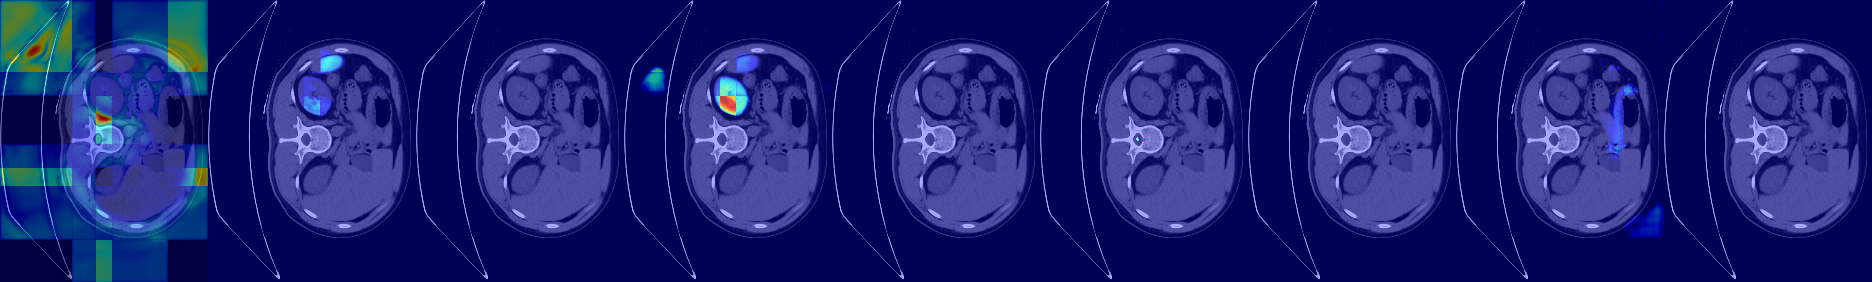

Counterfactual-CAM


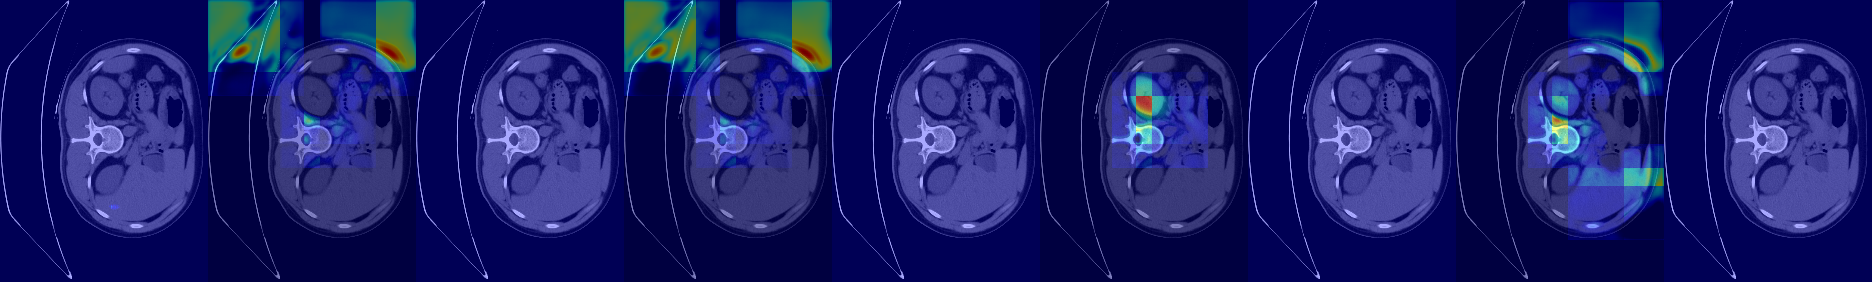

Negative Grad-CAM


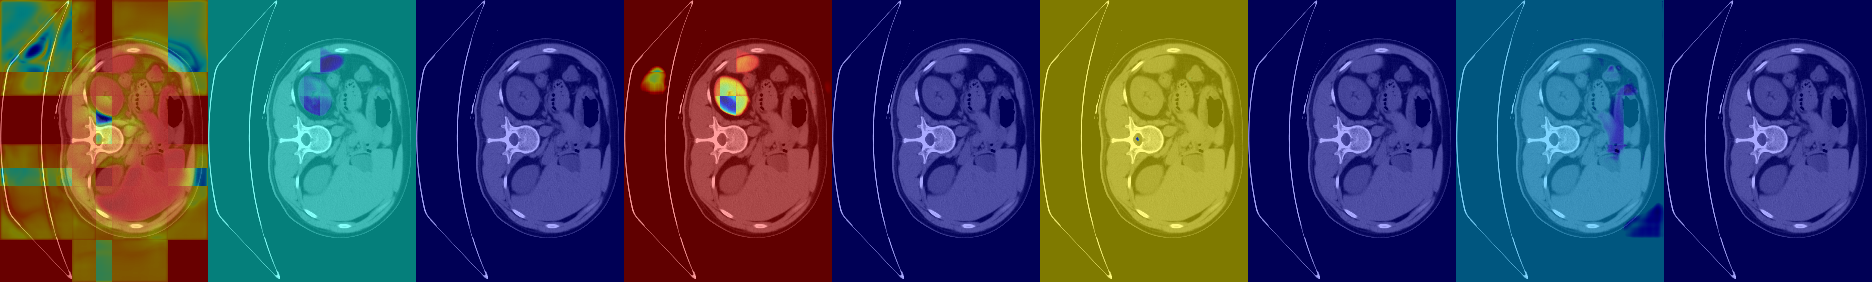

In [15]:
image_np = image[0, 0, :, :, [index]].cpu().numpy()
for category in range(9):
    grayscale_cam_np = grayscale_cam[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)
        
print("Grad-CAM")
display(Image.fromarray(result))

for category in range(9):
    grayscale_cam_np = grayscale_cfcam[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)

print("Counterfactual-CAM")
display(Image.fromarray(result))

for category in range(9):
    grayscale_cam_np = grayscale_negcam[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)

print("Negative Grad-CAM")
display(Image.fromarray(result))

### Last Convolution Layer in `feat_extractor`

In [17]:
target_layers=[module.feat_extractor.down_4]

cam_calculator = CAMCalculationModule(module, target_layers)
counterfactual_calculator = CounterfactualCalculation(module, target_layers)
neg_cam_calculator = NegCAMCalculation(module, target_layers)

grayscale_cam2 = {}
grayscale_cfcam2 = {}
grayscale_negcam2 = {}

for i in range(9):
    grayscale_cam2[i] = cam_calculator.get_cam(image, label, category=i)
    grayscale_cfcam2[i] = counterfactual_calculator.get_cam(image, label, category=i)
    grayscale_negcam2[i] = neg_cam_calculator.get_cam(image, label, category=i)

Grad-CAM


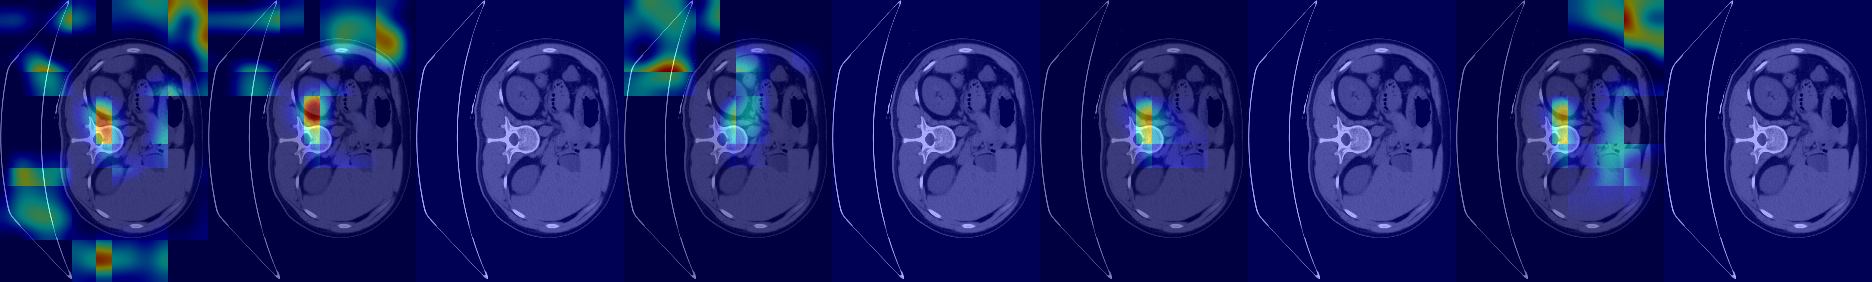

Counterfactual-CAM


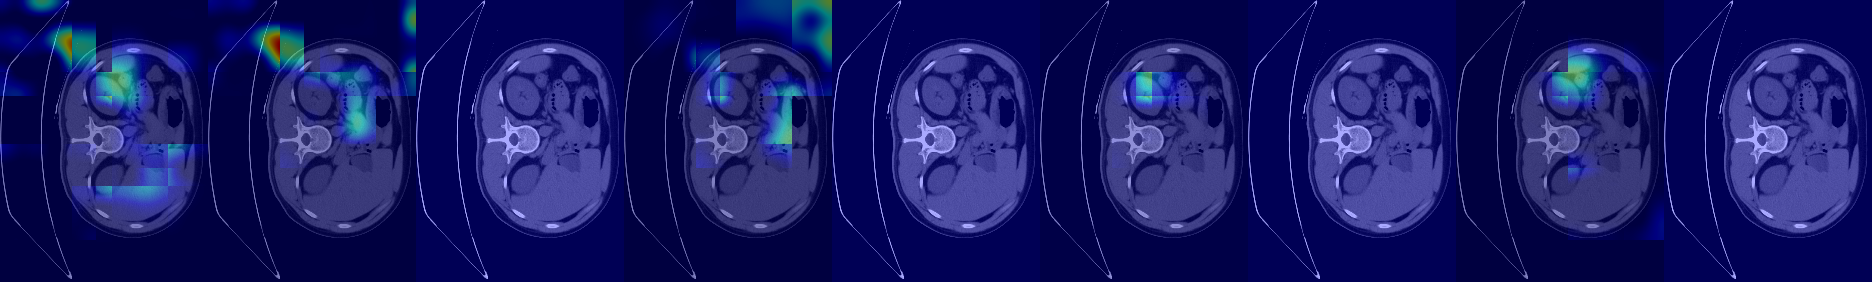

Negative Grad-CAM


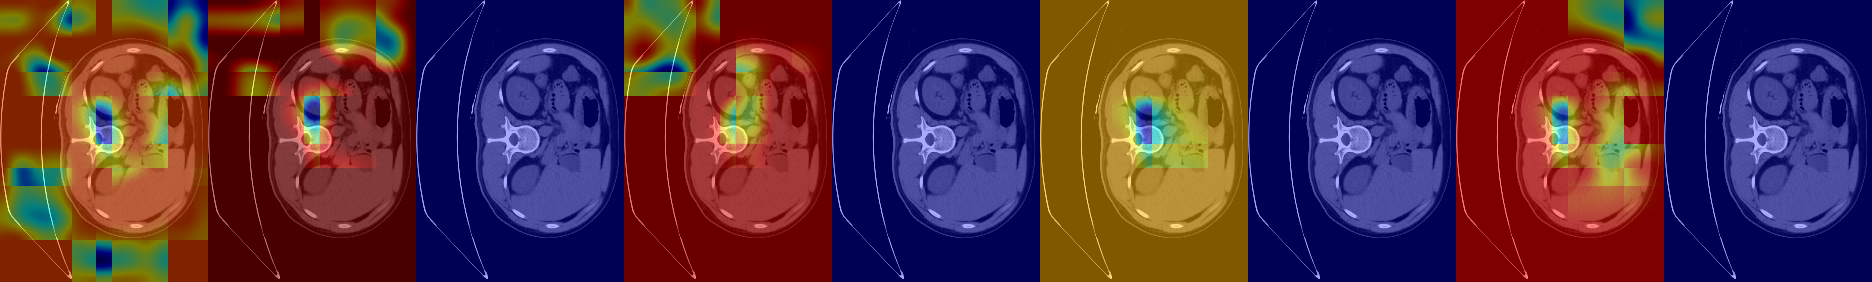

In [18]:
image_np = image[0, 0, :, :, [index]].cpu().numpy()
for category in range(9):
    grayscale_cam_np = grayscale_cam2[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)

print("Grad-CAM")
display(Image.fromarray(result))

for category in range(9):
    grayscale_cam_np = grayscale_cfcam2[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)
        
print("Counterfactual-CAM")
display(Image.fromarray(result))

for category in range(9):
    grayscale_cam_np = grayscale_negcam2[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)

print("Negative Grad-CAM")
display(Image.fromarray(result))

## Prediction and Ground Truth

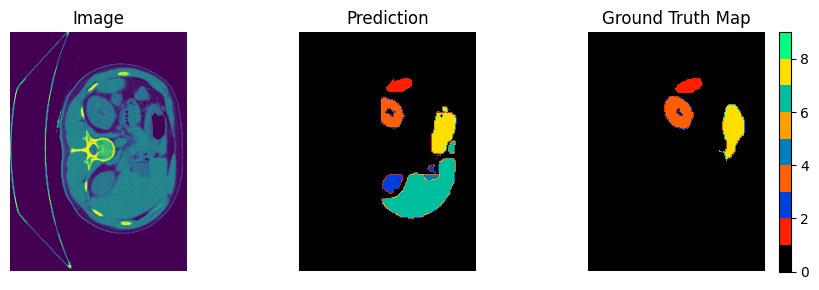

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

classes = {
    "0": "background",
    "1": "spleen",
    "2": "right kidney",
    "3": "left kidney",
    "4": "gall bladder",
    "5": "esophagus",
    "6": "liver",
    "7": "stomach",
    "8": "pancreas",
}

winter = plt.get_cmap('winter', data_info["num_classes"])
winter = winter(range(data_info["num_classes"]))
autumn = plt.get_cmap('autumn', data_info["num_classes"])
autumn = autumn(range(data_info["num_classes"]))
custom_colors = np.array(
    [winter[i, :] if i % 2 == 0 else autumn[i, :] for i in range(data_info["num_classes"])]
)
custom_colors[0] = np.array([0, 0, 0, 1])
custom_cmap = ListedColormap(custom_colors, name='custom_colormap', N=len(custom_colors))


with torch.no_grad(): # important!
    _image = torch.argmax(module.inference(image.to(device)), dim=1, keepdim=True)

slice = index

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
cmap = custom_cmap

# Plot the image in the first subplot
image_data = image[0, 0, :, :, slice].cpu().numpy()
ax1.imshow(image_data)
ax1.axis('off')  # Turn off axis labels and ticks
ax1.set_title('Image')

# Plot the prediction in the second subplot
_image_data = _image[0, 0, :, :, slice].cpu().numpy()
_image_data[0, 0:data_info["num_classes"]] = range(data_info["num_classes"])
ax2.imshow(_image_data, cmap=cmap, vmin=0, vmax=data_info["num_classes"])
ax2.axis('off')  # Turn off axis labels and ticks
ax2.set_title('Prediction')

# Plot the ground truth map in the second subplot with the corresponding colormap
ground_truth_map_np = label[0, 0, :, :, slice].cpu().numpy().astype(int)
ground_truth_map_np[0, 0:data_info["num_classes"]] = range(data_info["num_classes"])
im3 = ax3.imshow(ground_truth_map_np, cmap=cmap, vmin=0, vmax=data_info["num_classes"])
ax3.axis('off')  # Turn off axis labels and ticks
ax3.set_title('Ground Truth Map')

# Add a colorbar to the second subplot
cbar = fig.colorbar(im3, ax=ax3)

# cbar.set_label('Class Labels')

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Dom_classifier

In [47]:
def identity(x):
    print(x)
    return x

def model_output_transform(category, label):
    def transform(model_output):
        # Implement transformation here
        if category == 1:
            mask = (model_output > 0.5) * 1
        elif category == 0:
            mask = (model_output < 0.5) * 1
        else:
            raise ValueError

        if torch.cuda.is_available():
            mask = mask.cuda()
        print(model_output)
        return model_output

    # Return a function
    return transform


class CAMCalculationModule(nn.Module):
    def __init__(self, model, target_layers):
        super().__init__()
        self.model = model
        self.target_layers = target_layers

    def forward(self, image_label, category):
        image = image_label[:, [0], :, :, :]
        label = image_label[:, [1], :, :, :]
        targets = [model_output_transform(category, label)]
        with GradCAM(model=self.model, target_layers=self.target_layers, use_cuda=torch.cuda.is_available()) as cam:
            grayscale_cam = cam(input_tensor=image, targets=targets)
        return torch.Tensor(grayscale_cam)[:, None, :]

    def get_cam(self, image, label, category):
        image_label = torch.cat([image, label], dim=1)
        return sliding_window_inference(
            image_label, roi_size=(96, 96, 96), sw_batch_size=2, predictor=self.forward, category=category
        )

class CounterfactualCalculation(CAMCalculationModule):
    def forward(self, image_label, category=-1):
        image = image_label[:, [0], :, :, :]
        label = image_label[:, [1], :, :, :]
        targets = [model_output_transform(category, label)]
        with Counterfactual(model=self.model, 
                            target_layers=self.target_layers, 
                            use_cuda=torch.cuda.is_available()) as cam:
            grayscale_cam = cam(input_tensor=image, targets=targets)
            return torch.Tensor(grayscale_cam)[:, None, :]
        raise RuntimeError("No CAM evaluated.")

class NegCAMCalculation(CAMCalculationModule):
    def forward(self, image_label, category=-1):
        image = image_label[:, [0], :, :, :]
        label = image_label[:, [1], :, :, :]
        targets = [model_output_transform(category, label)]
        with GradCAM(model=self.model, target_layers=self.target_layers, use_cuda=torch.cuda.is_available()) as cam:
            grayscale_cam = -cam(input_tensor=image, targets=targets)
        return torch.Tensor(grayscale_cam)[:, None, :]
    
    def get_cam(self, image, label, category):
        image_label = torch.cat([image, label], dim=1)
        cam = sliding_window_inference(
            image_label, roi_size=(96, 96, 96), sw_batch_size=2, predictor=self.forward, category=category
        )
        cam = cam - torch.Tensor(np.min(cam.cpu().numpy(), axis=(2, 3), keepdims=True))
        return cam

In [35]:
x1 = torch.randn(2, 1, 96, 96, 96).cuda()
x2 = torch.randn(2, 1, 96, 96, 96).cuda()
_, feature1 = module.feat_extractor(x1)
_, feature2 = module.feat_extractor(x2)
module.dom_classifier(torch.cat([feature1, feature2], dim=1).cuda())


tensor([[0.0421],
        [0.0421]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [14]:
module.dom_classifier

Sequential(
  (0): Conv3d(512, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=64, out_features=1, bias=True)
)

In [36]:
from torch import nn
test_dom_classifier = nn.Sequential(
    nn.Conv3d(512, 128, kernel_size=3, padding=1), 
    nn.MaxPool3d(kernel_size=2),
    nn.ReLU(),
    nn.Conv3d(128, 64, kernel_size=3, padding=1),
    # nn.MaxPool3d(kernel_size=2),
    # nn.ReLU(),
)

with torch.no_grad():
    for param1, param2 in zip(module.dom_classifier.parameters(), test_dom_classifier.parameters()):
        if param1.shape == param2.shape:
            param2.copy_(param1)

test_dom_classifier.to(device)

Sequential(
  (0): Conv3d(512, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

In [37]:
test_dom_classifier(torch.cat([feature1, feature2], dim=1).cuda())

tensor([[[[[-251.9396, -381.0126, -221.1734],
           [-318.2858, -425.8681, -231.4336],
           [-169.6389, -211.4771, -103.5566]],

          [[-300.2857, -442.8738, -224.2165],
           [-351.2868, -503.1105, -228.8842],
           [-181.5652, -247.3914, -103.4808]],

          [[-180.2750, -264.3586, -108.5544],
           [-206.7977, -305.0420, -105.9656],
           [-109.8339, -152.6412,  -49.4969]]],


         [[[ -48.6364,  -66.2149,  -35.7038],
           [ -50.5292,  -95.0040,  -42.4401],
           [ -24.1640,  -47.0460,  -29.6797]],

          [[ -54.0253,  -74.6265,  -42.2456],
           [ -55.5725, -103.5417,  -50.8816],
           [ -28.3114,  -51.1977,  -37.6286]],

          [[ -29.5736,  -44.0798,  -25.9108],
           [ -31.7157,  -54.0811,  -27.3715],
           [ -17.0165,  -28.0836,  -21.5687]]],


         [[[ -63.5868,  -76.9566,  -53.5243],
           [ -90.0959, -109.3389,  -65.6306],
           [ -57.0266,  -82.5461,  -45.3841]],

          [[ -64

In [ ]:
module.default_forward_branch = 1
target_layers=[module.dom_classifier[5]]

cam_calculator = CAMCalculationModule(module, target_layers)
counterfactual_calculator = CounterfactualCalculation(module, target_layers)
neg_cam_calculator = NegCAMCalculation(module, target_layers)

grayscale_cam3 = {}
grayscale_cfcam3 = {}
grayscale_negcam3 = {}

for i in range(2):
    grayscale_cam3[i] = cam_calculator.get_cam(image, label, category=i)
    grayscale_cfcam3[i] = counterfactual_calculator.get_cam(image, label, category=i)
    grayscale_negcam3[i] = neg_cam_calculator.get_cam(image, label, category=i)

Grad-CAM


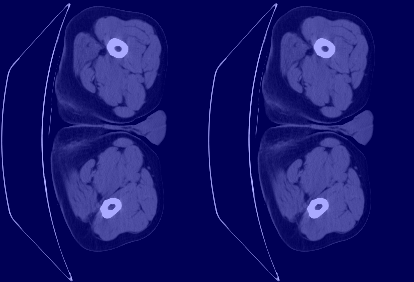

Counterfactual-CAM


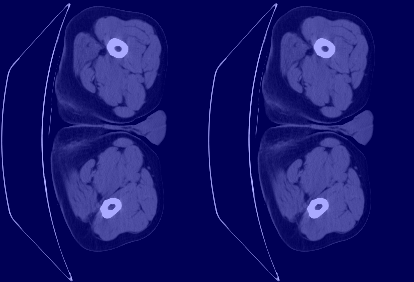

Negative Grad-CAM


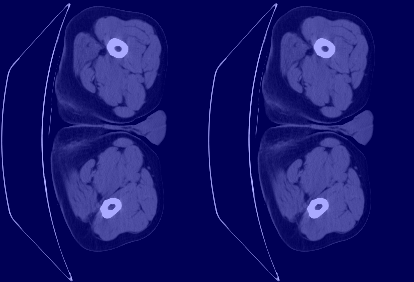

In [25]:
index = 4

image_np = image[0, 0, :, :, [index]].cpu().numpy()
for category in range(2):
    grayscale_cam_np = grayscale_cam3[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)

print("Grad-CAM")
display(Image.fromarray(result))

for category in range(2):
    grayscale_cam_np = grayscale_cfcam3[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)
        
print("Counterfactual-CAM")
display(Image.fromarray(result))

for category in range(2):
    grayscale_cam_np = grayscale_negcam3[category][0, 0, :, :, index].cpu().numpy()
    cam_image = show_cam_on_image(image_np, grayscale_cam_np, use_rgb=True)
    if category == 0:
        result = cam_image
    else:
        result= np.concatenate((result, cam_image), axis=1)

print("Negative Grad-CAM")
display(Image.fromarray(result))